<a href="https://colab.research.google.com/github/JasmineAdvanture/fatty-liver-project/blob/BDS-11/MAFLD_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving NTCMRC_all.xlsx to NTCMRC_all.xlsx


In [3]:
#Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [4]:
#read dataset as df
df = pd.read_excel("NTCMRC_all.xlsx")

# Create a copy of df as df1
df1 = df.copy()

# Replace '\\N' with NaN
df1 = df1.replace('\\N', np.nan)

# Specify the columns to be converted to float
columns_to_convert1 = ['BMI', 'Triglyceride_y', 'gamgt', 'waist_y', 'mst', 'egfrn', 'Estimated_GFR_x', 'Alb_Cre_ratio', 'HOMA_IR', 'HS_CRP', \
                       'LDL_C_direct', 'LDL_C_HDL_C', 'Adiponectin', 'Leptin', 'Uric_Acid','Insulin', 'ALT_GPT']

# Specify the columns to be converted to int
columns_to_convert2 = ['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)', 'smoke', 'smoke_q']


# Convert the specified columns to float and fill missing/unconvertible values with NaN
for column in columns_to_convert1:
    df1[column] = pd.to_numeric(df1[column], errors='coerce')

# Convert the specified columns to int and fill missing/unconvertible values with NaN
for column in columns_to_convert2:
    df1[column] = pd.to_numeric(df1[column], errors='coerce').astype(float).astype(pd.Int64Dtype())


# Calculate FLI using the formula and defined as df2
df2 = df1.copy()
df2['FLI'] = (np.exp(0.953 * np.log(df2['Triglyceride_y']) + 0.139 * df2['BMI'] + 0.718 * np.log(df2['gamgt']) \
     + 0.053 * df2['waist_y'] - 15.745)) / (1 + np.exp(0.953 * np.log(df2['Triglyceride_y']) \
    + 0.139 * df2['BMI'] + 0.718 * np.log(df2['gamgt']) + 0.053 * df2['waist_y'] - 15.745)) * 100

# Derive FL_echo based on ultrasound results column
df2['FL_echo'] = df2['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)']
df2['FL_echo'] = df2['FL_echo'].replace('<NA>', np.nan)

#Derive fl_status column based on fl_echo and FLI(when available): 1 for positive; 0 for negative; -1 for unavailable
def derive_fl_status(row):
    # Derive FL_Check column to infer the status by echo or FLI
    liver_status = row['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)']
    fli_value = row['FLI']

    if pd.isna(liver_status) and pd.isna(fli_value):
        return -1
    elif pd.notna(liver_status) and liver_status != 0:
        return 1
    elif pd.notna(fli_value) and fli_value >= 60:
        return 1
    else:
        return 0

df2['fl_status'] = df2.apply(derive_fl_status, axis=1)

#Derive homa_ir_check, hs_crp_check, and mst_total to determine MAFLD risk factors
df2['homa_ir_check'] = df2['HOMA_IR'].apply(lambda x: 1 if x >= 2.5 else 0)
df2['hs_crp_check'] = df2['HS_CRP'].apply(lambda x: 1 if x > 2 else 0)
df2['mst_total'] = df2[['w', 'hyper', 'HDL', 'fg', 'trig', 'homa_ir_check', 'hs_crp_check']].sum(axis=1)

In [5]:
#Derive target variables and named as df3
def derive_MAFLD(df):
    df['MAFLD'] = 0  # Initialize MAFLD field as 0

    # Condition 1: fl_status = -1
    df.loc[df['fl_status'] == -1, 'MAFLD'] = -1

    # Condition 2: fl_check = 0
    df.loc[df['fl_status'] == 0, 'MAFLD'] = 0

    # Condition 3: fl_check = 1
    # Subcondition 1: BMI >= 23
    df.loc[(df['fl_status'] == 1) & (df['BMI'] >= 23), 'MAFLD'] = 1

    # Subcondition 2: BMI < 23 and mst >= 2
    df.loc[(df['fl_status'] == 1) & (df['BMI'] < 23) & (df['mst_total'] >= 2), 'MAFLD'] = 1

    # Subcondition 3: DM_determine = 1
    df.loc[(df['fl_status'] == 1) & (df['DM_determine'] == 1), 'MAFLD'] = 1

    return df

def derive_CKD(df):
    # Initialize CKD field as -1
    df['CKD'] = -1

    # Condition 1: egfrn >= 60 and Alb_Cre_ratio < 3
    df.loc[(df['Estimated_GFR_x'] >= 60) & (df['Alb_Cre_ratio'] < 3), 'CKD'] = 1

    # Condition 2: egfrn >= 60 and 3 <= Alb_Cre_ratio <= 30 or 45 <= egfrn < 60 and Alb_Cre_ratio < 3
    df.loc[((df['Estimated_GFR_x'] >= 60) & (df['Alb_Cre_ratio'].between(3, 30))) |
           ((df['Estimated_GFR_x'].between(45, 60)) & (df['Alb_Cre_ratio'] < 3)), 'CKD'] = 2

    # Condition 3: egfrn >= 60 and Alb_Cre_ratio > 30 or egfrn < 60 and Alb_Cre_ratio >= 0
    df.loc[((df['Estimated_GFR_x'] >= 60) & (df['Alb_Cre_ratio'] > 30)) |
           ((df['Estimated_GFR_x'] < 60) & (df['Alb_Cre_ratio'] >= 0)), 'CKD'] = 3

    # Set CKD as 0 for cases where egfrn and Alb_Cre_ratio are not empty and CKD is still -1
    df.loc[(df['Estimated_GFR_x'].notnull()) & (df['Alb_Cre_ratio'].notnull()) & (df['CKD'] == -1), 'CKD'] = 0

    return df

df3 = derive_CKD(derive_MAFLD(df2))

In [6]:
# Derive FL_group_list, 对CMRC_id分组并计算每个病人的FL_Check的唯一值
grouped = df2.groupby('CMRC_id')['fl_status'].unique()
df2['fl_group_list'] = df2.groupby('CMRC_id')['fl_status'].transform(lambda x: [x.unique().tolist()] * len(x))

# Derive patient_fl_validity according to FL_group_list conditions
def assign_patient_fl_validity(df):
    df['patient_fl_validity'] = -1  # 初始化所有记录为第三组 (-1)

    def get_patient_valid(group_list):
        if isinstance(group_list, list):
            if -1 in group_list and len(group_list) == 1:
                return "unavailable"  # 第三组 (-1)
            elif -1 in group_list:
                return "partial"  # 第二组 (0)
            else:
                return "completed"  # 第一组 (1)
        else:
            return "others"  # 第三组 (-1)

    df['patient_fl_validity'] = df['fl_group_list'].apply(get_patient_valid)

    return df


#assign patient valid value
df4 = assign_patient_fl_validity(df3)

In [7]:
def sliding_window_data(df, input_window_size, target_window_size):
    transformed_data = []
    group_counter = {}

    df_sorted = df.sort_values(['CMRC_id', 'year_come'])

    for patient_id, group in df_sorted.groupby('CMRC_id'):
        if len(group) < input_window_size + target_window_size:
            continue


        group_counter.setdefault(patient_id, 0)
        group_counter[patient_id] += 1
        group_alias = f'{patient_id}_group{group_counter[patient_id]}'

        for i in range(len(group) - input_window_size - target_window_size + 1):
            input_data = group[i:i+input_window_size]
            target_data = group[i+input_window_size:i+input_window_size+target_window_size]

            # Flatten input_data and repeat target_data
            input_features_t1 = input_data.iloc[0, :].values.flatten()
            input_features_t2 = input_data.iloc[1, :].values.flatten()
            t3_MAFLD = target_data['MAFLD'].values

            new_row = [group_alias] + list(input_features_t1) + list(input_features_t2) + list(t3_MAFLD)

            transformed_data.append(new_row)

    columns_list = ['CMRC_id'] + [f't1_{col}' for col in input_data.columns] + [f't2_{col}' for col in input_data.columns] + [f't3_MAFLD']
    transformed_df = pd.DataFrame(transformed_data, columns=columns_list)
    return transformed_df


# Sliding window implementation, ie. use previous 2 years record to predict the 3 year MAFLD status
df5 = sliding_window_data(df4, input_window_size=2, target_window_size=1)


In [8]:
# Filter available data that can be applied to models
df6 = df5[(df5['t3_MAFLD'] != -1)]

# # Replace '\\N' with NaN
# df6 = df6.replace('\\N', np.nan)

# Drop ID relevant cols in the dataset
columns_to_drop = ['CMRC_id', 't1_CMRC_id', 't2_CMRC_id', 't1_sid', 't2_sid', 't1_P_Number','t2_P_Number']
df7 = df6.drop(columns=columns_to_drop)

In [9]:
#checks
df7[['t3_MAFLD']].value_counts(dropna=False).reset_index()


,t3_MAFLD,0
0,0,7614
1,1,2044


In [10]:
#Select key columns for conventional machine learning models

# This function is for adding prefix for cols, the cols should be a list of column names that needs to add prefix(such as "t1_" in this project)
def add_prefix(cols, prefixes):
# Note the prefixes should be a LIST, eg. prefixes = ["t1_", "t2_"]
    renamed_columns = []
    for prefix in prefixes:
        renamed_columns.extend([prefix + column for column in cols])
    return renamed_columns

columns = ["sex", "age", "waist_y", "Glucose_AC_y", "Triglyceride_y", "HDL_C_y", "AST_GOT", "ALT_GPT", \
          "gamgt", "Insulin", "T_Cholesterol", "LDL_C_direct", "VLDL_C", "Non_HDL_C", "T_CHOL_HDL_C", \
          "LDL_C_HDL_C", "HS_CRP", "Hb_A1c", "Uric_Acid", "HBsAg_x", "Anti_HCV_x", "HOMA_IR", "Adiponectin", \
           "Leptin", "TotalVitaminD", "smoke", "smoke_q", "coffee", "betel", "BMI", "DM_determine", "w", "hyper", \
           "fg", "HDL", "trig", "sarcf", "ms2", "MNA", "AUDIT", "HBV_", "HCV_", "MAFLD", "CKD"]
prefixes = ["t1_", "t2_"]
renamed_columns = add_prefix(columns, prefixes)

df8 = df7[renamed_columns]
df8['t3_MAFLD'] = df7['t3_MAFLD']


<ipython-input-10-6e777a764f01>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['t3_MAFLD'] = df7['t3_MAFLD']


In [28]:
df8_check = df8.copy()
import re

# df8_check['HBsAg_x_text'] = df8_check['t1_HBsAg_x'].str.split().str[0]
df8_check['HBsAg_x_text'] = df8_check['t1_HBsAg_x'].str.extract(r'(\w+)')

# df8_check['t1_Anti_HCV_x_text'] = df8_check['t1_Anti_HCV_x'].str.split().str[0]
df8_check['t1_Anti_HCV_x_text'] = df8_check['t1_Anti_HCV_x'].str.extract(r'(\w+)')


In [31]:
df8_check['t1_Anti_HCV_x_text'].value_counts(dropna=False)

Nonreactive     5825
NaN             3606
Reactive         179
陰性                27
Nonreactive0      17
陽性                 2
NONE               1
Equivocal          1
Name: t1_Anti_HCV_x_text, dtype: int64

In [32]:
#Extract text value for ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x']
import re

def extract_text_value(value):
    match = re.search(r'(\w+)', str(value))
    if match:
        return match.group(1)
    else:
        return None

# extract text values for these cols and rename them as *_text
columns_to_extract = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x']

df9 = df8.copy()
for column in columns_to_extract:
    new_column_name = column + '_text'
    df9[new_column_name] = df9[column].apply(extract_text_value)

df9['t1_Anti_HCV_x_text'].value_counts()

Nonreactive     5825
nan             3605
Reactive         179
陰性                27
Nonreactive0      17
陽性                 2
NONE               1
0                  1
Equivocal          1
Name: t1_Anti_HCV_x_text, dtype: int64

In [33]:
df9['t1_HBsAg_x_text'].value_counts()

Nonreactive     5270
nan             3606
Reactive         660
Equivocal         74
陰性                26
Nonreactive0      17
陽性                 3
NONE               1
0                  1
Name: t1_HBsAg_x_text, dtype: int64

In [37]:
df9[df9['t1_HBsAg_x_text'] == '0']

,t1_sex,t1_age,t1_waist_y,t1_Glucose_AC_y,t1_Triglyceride_y,t1_HDL_C_y,t1_AST_GOT,t1_ALT_GPT,t1_gamgt,t1_Insulin,t1_T_Cholesterol,t1_LDL_C_direct,t1_VLDL_C,t1_Non_HDL_C,t1_T_CHOL_HDL_C,t1_LDL_C_HDL_C,t1_HS_CRP,t1_Hb_A1c,t1_Uric_Acid,t1_HBsAg_x,t1_Anti_HCV_x,t1_HOMA_IR,t1_Adiponectin,t1_Leptin,t1_TotalVitaminD,t1_smoke,t1_smoke_q,t1_coffee,t1_betel,t1_BMI,t1_DM_determine,t1_w,t1_hyper,t1_fg,t1_HDL,t1_trig,t1_sarcf,t1_ms2,t1_MNA,t1_AUDIT,t1_HBV_,t1_HCV_,t1_MAFLD,t1_CKD,t2_sex,t2_age,t2_waist_y,t2_Glucose_AC_y,t2_Triglyceride_y,t2_HDL_C_y,t2_AST_GOT,t2_ALT_GPT,t2_gamgt,t2_Insulin,t2_T_Cholesterol,t2_LDL_C_direct,t2_VLDL_C,t2_Non_HDL_C,t2_T_CHOL_HDL_C,t2_LDL_C_HDL_C,t2_HS_CRP,t2_Hb_A1c,t2_Uric_Acid,t2_HBsAg_x,t2_Anti_HCV_x,t2_HOMA_IR,t2_Adiponectin,t2_Leptin,t2_TotalVitaminD,t2_smoke,t2_smoke_q,t2_coffee,t2_betel,t2_BMI,t2_DM_determine,t2_w,t2_hyper,t2_fg,t2_HDL,t2_trig,t2_sarcf,t2_ms2,t2_MNA,t2_AUDIT,t2_HBV_,t2_HCV_,t2_MAFLD,t2_CKD,t3_MAFLD,t1_HBsAg_x_text,t2_HBsAg_x_text,t1_Anti_HCV_x_text,t2_Anti_HCV_x_text
5994,1,68,80.0,97.0,120.0,64.7,33.0,28.0,19.0,3.8,179.0,75.5,24.0,114.0,2.77,1.17,1.207,5.5,4.6,0,0,0.910123,0.0,0.0,46.41,0,0,0.0,0.0,20.83,0,0,0,0,0,0,0.0,0,3.0,0.0,NaN,NaN,0,2,1,69,80.0,90.0,78.0,71.0,28.0,21.0,20.0,2.76,163.0,67.4,16.0,92.0,2.3,0.95,4.144,5.4,5.5,Reactive 7781.00,Reactive 1.150,0.613333,NaN,NaN,32.81,0,0,0.0,0.0,20.61,0,0,0,0,0,0,NaN,0,NaN,14.0,1.0,1.0,0,2,0,0,Reactive,0,Reactive


In [79]:
# Deal with HBsAg_x, Anti_HCV_x, (values eg. 陰性    0.351)
# This function will extract the numeric values
import re
def extract_numeric_value(value):
    pattern = r'\d+(\.\d+)?'  # 正则表达式模式，匹配一个或多个数字（包括小数点）
    match = re.search(pattern, str(value))
    if match:
        return float(match.group())
    else:
        return None

# extract numeric values for these cols and rename that as  *_num
columns_to_extract = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x']

df9 = df8.copy()
for column in columns_to_extract:
    new_column_name = column + '_num'
    df9[new_column_name] = df9[column].apply(extract_numeric_value)

# Specify the columns to be converted to float
columns_to_convert1 = ['t1_LDL_C_direct', 't1_LDL_C_HDL_C', 't1_Adiponectin', 't1_Leptin', 't1_Uric_Acid','t1_Insulin', \
                       't2_LDL_C_direct', 't2_LDL_C_HDL_C', 't2_Adiponectin', 't2_Leptin', 't2_Uric_Acid','t2_Insulin']

# Specify the columns to be converted to int
columns_to_convert2 = ['t1_sex', 't1_w', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', \
                        't2_w', 't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel']

# Convert the specified columns to float and fill missing/unconvertible values with NaN
for column in columns_to_convert1:
    df9[column] = pd.to_numeric(df9[column], errors='coerce')

# Convert the specified columns to int and fill missing/unconvertible values with NaN
for column in columns_to_convert2:
    df9[column] = pd.to_numeric(df9[column], errors='coerce').astype(float).astype(pd.Int64Dtype())

In [125]:
# drop these cols as those been derived for numeric cols, alias *_num
cols_to_drop_only_MAFLD = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x', 't1_MAFLD', 't2_MAFLD', 't2_sex']
cols_to_drop_fli_related = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x', 't1_MAFLD', 't2_MAFLD', 't2_sex', \
                            't1_Triglyceride_y', 't1_BMI', 't1_gamgt', 't1_waist_y', 't1_gamgt', 't1_w', \
                            't2_Triglyceride_y', 't2_BMI', 't2_gamgt', 't2_waist_y', 't2_gamgt', 't2_w']
df9_a = df9.drop(cols_to_drop_only_MAFLD, axis=1)

#FLI related cols: Triglyceride_y, BMI, gamgt, waist_y, gamgt
df9_b = df9.drop(cols_to_drop_fli_related, axis=1)

#Modeling and Performance Evaluation
1. Conventional Machine Learning models - Logistic Regression, KNN, SVM, Random Forest;
2. Dataset: df9_a for predictors include all important variables; d9_b for predictors exclude all FLI related ones


In [126]:
#check df9_a all cols datatypes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# print(df9_a.dtypes)
print(df9_a.columns.tolist())


['t1_sex', 't1_age', 't1_waist_y', 't1_Glucose_AC_y', 't1_Triglyceride_y', 't1_HDL_C_y', 't1_AST_GOT', 't1_ALT_GPT', 't1_gamgt', 't1_Insulin', 't1_T_Cholesterol', 't1_LDL_C_direct', 't1_VLDL_C', 't1_Non_HDL_C', 't1_T_CHOL_HDL_C', 't1_LDL_C_HDL_C', 't1_HS_CRP', 't1_Hb_A1c', 't1_Uric_Acid', 't1_HOMA_IR', 't1_Adiponectin', 't1_Leptin', 't1_TotalVitaminD', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_BMI', 't1_DM_determine', 't1_w', 't1_hyper', 't1_fg', 't1_HDL', 't1_trig', 't1_sarcf', 't1_ms2', 't1_MNA', 't1_AUDIT', 't1_HBV_', 't1_HCV_', 't1_CKD', 't2_age', 't2_waist_y', 't2_Glucose_AC_y', 't2_Triglyceride_y', 't2_HDL_C_y', 't2_AST_GOT', 't2_ALT_GPT', 't2_gamgt', 't2_Insulin', 't2_T_Cholesterol', 't2_LDL_C_direct', 't2_VLDL_C', 't2_Non_HDL_C', 't2_T_CHOL_HDL_C', 't2_LDL_C_HDL_C', 't2_HS_CRP', 't2_Hb_A1c', 't2_Uric_Acid', 't2_HOMA_IR', 't2_Adiponectin', 't2_Leptin', 't2_TotalVitaminD', 't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_BMI', 't2_DM_determine', 't2_w', 't2_hyp

In [127]:
# split categorical and numerical variables
categorical_features = ['t1_sex', 't1_w', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
                        't2_w', 't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']
numeric_features = df9_a.columns.drop(categorical_features)
X_categorical = df9_a[categorical_features]
X_numeric = df9_a[numeric_features]
y = df9_a['t3_MAFLD']

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# # concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

X_conbined shape:  (9658, 115)
y shape:  (9658,)


In [117]:
X_combined.head(5)

,t1_age,t1_waist_y,t1_Glucose_AC_y,t1_Triglyceride_y,t1_HDL_C_y,t1_AST_GOT,t1_ALT_GPT,t1_gamgt,t1_Insulin,t1_T_Cholesterol,t1_LDL_C_direct,t1_VLDL_C,t1_Non_HDL_C,t1_T_CHOL_HDL_C,t1_LDL_C_HDL_C,t1_HS_CRP,t1_Hb_A1c,t1_Uric_Acid,t1_HOMA_IR,t1_Adiponectin,t1_Leptin,t1_TotalVitaminD,t1_BMI,t1_hyper,t1_fg,t1_HDL,t1_trig,t1_sarcf,t1_ms2,t1_MNA,t1_AUDIT,t1_HBV_,t1_HCV_,t2_age,t2_waist_y,t2_Glucose_AC_y,t2_Triglyceride_y,t2_HDL_C_y,t2_AST_GOT,t2_ALT_GPT,t2_gamgt,t2_Insulin,t2_T_Cholesterol,t2_LDL_C_direct,t2_VLDL_C,t2_Non_HDL_C,t2_T_CHOL_HDL_C,t2_LDL_C_HDL_C,t2_HS_CRP,t2_Hb_A1c,t2_Uric_Acid,t2_HOMA_IR,t2_Adiponectin,t2_Leptin,t2_TotalVitaminD,t2_BMI,t2_hyper,t2_fg,t2_HDL,t2_trig,t2_sarcf,t2_ms2,t2_MNA,t2_AUDIT,t2_HBV_,t2_HCV_,t3_MAFLD,t1_HBsAg_x_num,t2_HBsAg_x_num,t1_Anti_HCV_x_num,t2_Anti_HCV_x_num,t1_sex_0,t1_sex_1,t1_w_0,t1_w_1,t1_smoke_0,t1_smoke_1,t1_smoke_<NA>,t1_smoke_q_0,t1_smoke_q_1,t1_smoke_q_2,t1_smoke_q_<NA>,t1_coffee_0,t1_coffee_1,t1_coffee_<NA>,t1_betel_0,t1_betel_1,t1_betel_<NA>,t1_DM_determine_0,t1_DM_determine_1,t1_CKD_-1,t1_CKD_1,t1_CKD_2,t1_CKD_3,t2_w_0,t2_w_1,t2_smoke_0,t2_smoke_1,t2_smoke_<NA>,t2_smoke_q_0,t2_smoke_q_1,t2_smoke_q_2,t2_smoke_q_<NA>,t2_coffee_0,t2_coffee_1,t2_coffee_<NA>,t2_betel_0,t2_betel_1,t2_betel_<NA>,t2_DM_determine_0,t2_DM_determine_1,t2_CKD_-1,t2_CKD_1,t2_CKD_2,t2_CKD_3
0,0.112647,0.129441,-0.027004,0.793641,-0.134864,-0.305200,-0.352104,-0.397066,0.071699,2.723389,2.192590,1.540520,2.868121,1.722508,1.478442,-0.124080,-0.179149,0.601191,0.001296,-0.150164,1.517274,0.203615,1.919639,0.970210,1.332998,-0.516034,1.868714,-0.515471,1.610696,0.083639,-0.506711,-0.353254,-0.175613,0.084907,0.200012,0.093246,0.751849,-0.207579,-0.748550,-0.371073,-0.444253,-0.469425,2.772747,2.242780,1.478550,2.929959,1.842842,1.604559,0.054947,-0.217601,0.451774,-0.331363,-0.319869,-0.259393,0.224150,1.890481,0.966396,1.326732,-0.501197,1.862586,-0.511566,1.599148,0.139593,-0.196276,-0.345164,-0.176162,-0.518124,-0.263853,-0.241746,-0.125669,-0.131059,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0
1,0.199871,0.228791,0.091083,0.743757,-0.173223,-0.858277,-0.408268,-0.443176,-0.346993,2.648380,2.269212,1.435644,2.790927,1.722508,1.589073,0.048097,-0.179149,0.454548,-0.255387,-0.249069,-0.226893,0.205638,1.924933,0.970210,1.332998,-0.516034,1.868714,-0.515471,1.610696,0.083639,-0.206434,-0.353254,-0.175613,0.259307,0.395749,0.053574,0.397947,0.096060,-0.503324,-0.187065,-0.313406,-0.640907,0.295208,-0.284054,0.773887,0.255906,-0.087367,-0.435842,-0.299663,-0.093987,0.305860,-0.448533,-0.319869,-0.259393,0.709632,2.158565,-1.034773,1.326732,-0.501197,1.862586,-0.511566,1.599148,0.139593,-0.506525,-0.345164,-0.176162,-0.518124,-0.263844,-0.241723,-0.125669,-0.131642,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
2,0.374320,0.427490,0.051721,0.394564,0.140040,-0.581738,-0.183612,-0.304845,-0.510939,0.173079,-0.305285,0.753948,0.114866,-0.195917,-0.476038,-0.279135,-0.055515,0.307906,-0.368291,-0.249069,-0.226893,0.686089,2.194916,-1.030705,1.332998,-0.516034,1.868714,-0.515471,1.610696,0.083639,-0.506711,-0.353254,-0.175613,0.346507,0.297881,0.370955,0.240657,1.477925,0.232353,0.180952,-0.357022,-0.411384,1.646593,0.997412,0.502862,1.078691,-0.356482,-0.423697,-0.125245,-0.093987,-0.285090,-0.256028,-0.319869,-0.259393,-0.019101,2.113884,0.966396,1.326732,-0.501197,1.862586,-0.511566,1.599148,0.139593,-0.506525,-0.345164,-0.176162,1.930039,-0.263827,-0.241746,-0.126599,-0.131059,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
3,0.461544,0.328141,0.366621,0.239367,1.565706,0.247877,0.265702,-0.350955,-0.291504,1.523243,1.000353,0.491757,0.938269,-0.463390,-0.463746,-0.118183,-0.055515,-0.285995,-0.182795,-0.249069,-0.226893,-0.035093,2.149918,0.970210,1.332998,-0.516034,1.868714,-0.515471,1.610696,0.083639,-0.506711,-0.353254,-0.175613,0.433707,0.591486,0.489973,1.240571,-0.505020,-0.339840,-0.003056

In [133]:


def split_train_test(df, target, test_size=0.3, random_state=101):
    """
    Perform train-test split on the given DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame containing features and target variables.
        target (str): The name of the target variable column.
        test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.3.
        random_state (int, optional): Random state for reproducibility. Default is 101.

    Returns:
        Tuple: X_train, X_test, y_train, y_test
    """
    features = df.columns.drop([target])
    X = df[features]
    y = df[target]

    # Deal with missing values
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

#Conventional Machine Learning Models
def logistic_regression_model(X_train, y_train, X_test, y_test):
    logmodel = LogisticRegression(max_iter=2000)
    logmodel.fit(X_train, y_train)

    # Evaluation
    predictions_log = logmodel.predict(X_test)
    probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

    # Calculate AUC
    auc_log = roc_auc_score(y_test, probabilities_log)

    return {
        "auc": auc_log,
        "coefficients": logmodel.coef_,
        "intercept": logmodel.intercept_,
        "classification_report": classification_report(y_test, predictions_log)
    }

def svm_model(X_train, y_train, X_test, y_test):
    svm_model = SVC(probability=True)
    svm_model.fit(X_train, y_train)

    # Evaluation
    predictions_svm = svm_model.predict(X_test)
    probabilities_svm = svm_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

    # Calculate AUC
    auc_svm = roc_auc_score(y_test, probabilities_svm)

    return {
        "auc": auc_svm,
        "classification_report": classification_report(y_test, predictions_svm)
    }


def random_forest_model(X_train, y_train, X_test, y_test):
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Evaluation
    predictions_rf = rf_model.predict(X_test)
    probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

    # Calculate AUC
    auc_rf = roc_auc_score(y_test, probabilities_rf)

    return {
        "auc": auc_rf,
        "classification_report": classification_report(y_test, predictions_rf)
    }

def kNearestNeighbor_model(X_train, y_train, X_test, y_test, n_neighbors=5):
    """
    Train and evaluate a K-Nearest Neighbors model.

    Parameters:
        X_train (array-like): Training features.
        y_train (array-like): Training target.
        X_test (array-like): Testing features.
        y_test (array-like): Testing target.
        n_neighbors (int, optional): Number of neighbors. Default is 5.

    Returns:
        dict: Dictionary containing the model's evaluation metrics.
    """
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)


    predictions = knn.predict(X_test)
    probabilities_knn = knn.predict_proba(X_test)  # Predict probabilities for each class
    probabilities_positive = probabilities_knn[:, 1]  # Extract probabilities for the positive class

    accuracy = accuracy_score(y_test, predictions)
    classification = classification_report(y_test, predictions)
    auc = roc_auc_score(y_test, probabilities_positive)

    return {"accuracy": accuracy, "classification_report": classification, "auc": auc}

def plot_knn_error_rate(X_train, y_train, X_test, y_test, max_k=40):
    error_rate = []

    # Calculate error rate for different K values
    for i in range(1, max_k+1):
        knn_model = KNeighborsClassifier(n_neighbors=i)
        knn_model.fit(X_train, y_train)
        pred_i = knn_model.predict(X_test)
        error_rate.append(np.mean(pred_i != y_test))

    # Plot the error rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k+1), error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()

In [134]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

scores = cross_val_score(model, X_combined, y, cv=5, scoring='roc_auc')

print('Cross-validation AUC scores:', scores)

Cross-validation AUC scores: [1. 1. 1. 1. 1.]


In [135]:
from sklearn.metrics import roc_auc_score, roc_curve
#Log model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print(auc_log)
print(classification_report(y_test, predictions_log))

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2276
           1       1.00      1.00      1.00       622

    accuracy                           1.00      2898
   macro avg       1.00      1.00      1.00      2898
weighted avg       1.00      1.00      1.00      2898



In [136]:
print("Starting for modeling with all important predictors except FLI related factors")
print("Logistic Regression Model AUC:", logistic_regression_model(X_train, y_train, X_test, y_test)["auc"])
print("KNN(N=9) Model AUC:", kNearestNeighbor_model(X_train, y_train, X_test, y_test, n_neighbors=9)["auc"])
print("SVM Model AUC:", svm_model(X_train, y_train, X_test, y_test)["auc"])
print("Random Forest Model AUC:", random_forest_model(X_train, y_train, X_test, y_test)["auc"])

Starting for modeling with all important predictors except FLI related factors
Logistic Regression Model AUC: 1.0
KNN(N=9) Model AUC: 0.9849064613837104
SVM Model AUC: 0.9999660938409461
Random Forest Model AUC: 1.0


In [137]:
# df9_b FLI related variables removed
# split categorical and numerical variables
categorical_features = ['t1_sex', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_DM_determine', 't1_CKD', \
                        't2_smoke', 't2_smoke_q', 't2_coffee', 't2_betel', 't2_DM_determine', 't2_CKD']
numeric_features = df9_b.columns.drop(categorical_features)
X_categorical = df9_b[categorical_features]
X_numeric = df9_b[numeric_features]
y = df9_b['t3_MAFLD']


print('X_numeric shape: ',X_numeric.shape)
print('y shape: ',y.shape)

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)
print('X_numeric_scaled shape: ',X_numeric_scaled.shape)

# Missing value handling
imputer = SimpleImputer(strategy='median')
X_numeric_scaled_imputed = imputer.fit_transform(X_numeric_scaled)
print('X_numeric_scaled_imputed shape: ',X_numeric_scaled_imputed.shape)

#dummy var
X_categorical_str = X_categorical.astype(str)
X_categorical_encoded = pd.get_dummies(X_categorical_str)

# # concat
X_numeric_scaled_imputed = pd.DataFrame(X_numeric_scaled_imputed, columns=X_numeric.columns)  # 转换为DataFrame
X_numeric_scaled_imputed.reset_index(drop=True, inplace=True)
X_categorical_encoded.reset_index(drop=True, inplace=True)
X_combined = pd.concat([X_numeric_scaled_imputed, X_categorical_encoded], axis=1)

print('X_conbined shape: ',X_combined.shape)
print('y shape: ',y.shape)


# train test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=2023)

X_numeric shape:  (9658, 63)
y shape:  (9658,)
X_numeric_scaled shape:  (9658, 63)
X_numeric_scaled_imputed shape:  (9658, 63)
X_conbined shape:  (9658, 103)
y shape:  (9658,)


In [138]:
print("Starting for modeling with all important predictors except FLI related factors")
print("Logistic Regression Model AUC:", logistic_regression_model(X_train, y_train, X_test, y_test)["auc"])
print("KNN(N=9) Model AUC:", kNearestNeighbor_model(X_train, y_train, X_test, y_test, n_neighbors=9)["auc"])
print("SVM Model AUC:", svm_model(X_train, y_train, X_test, y_test)["auc"])
print("Random Forest Model AUC:", random_forest_model(X_train, y_train, X_test, y_test)["auc"])

Starting for modeling with all important predictors except FLI related factors
Logistic Regression Model AUC: 1.0
KNN(N=9) Model AUC: 0.9849064613837104
SVM Model AUC: 0.9999660938409461
Random Forest Model AUC: 1.0


In [ ]:
#End Jun 26

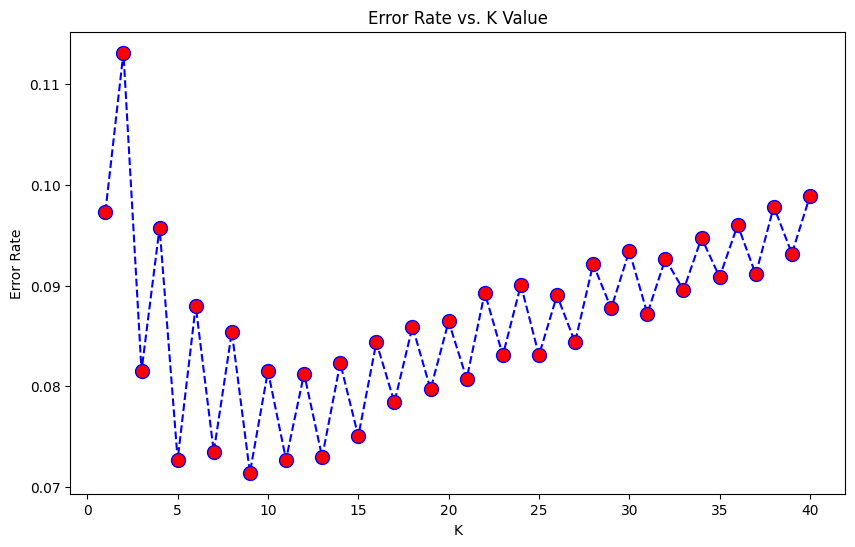

In [112]:
# train test split for df9_a
# target_variable = 't3_MAFLD'
# X_train, X_test, y_train, y_test = split_train_test(df9_a, target_variable)

#Find K for KNN model
plot_knn_error_rate(X_train, y_train, X_test, y_test)

In [111]:
print("Starting for modeling with all important predictors")
print("Logistic Regression Model AUC:", logistic_regression_model(X_train, y_train, X_test, y_test)["auc"])
print("KNN Model AUC:", kNearestNeighbor_model(X_train, y_train, X_test, y_test, n_neighbors=6)["auc"])
print("SVM Model AUC:", svm_model(X_train, y_train, X_test, y_test)["auc"])
print("Random Forest Model AUC:", random_forest_model(X_train, y_train, X_test, y_test)["auc"])

Starting for modeling with all important predictors
Logistic Regression Model AUC: 1.0
KNN Model AUC: 0.9696635102871449
SVM Model AUC: 0.9999842121819593
Random Forest Model AUC: 1.0


df9_b modeling

In [ ]:
# train test split for df9_b
# Predictors exclude all FLI related calculators
target_variable = 't3_MAFLD'
X_train, X_test, y_train, y_test = split_train_test(df9_b, target_variable)

#Find K for KNN model
plot_knn_error_rate(X_train, y_train, X_test, y_test)

In [113]:
print("Starting for modeling with all important predictors except FLI related factors")
print("Logistic Regression Model AUC:", logistic_regression_model(X_train, y_train, X_test, y_test)["auc"])
print("KNN(N=7) Model AUC:", kNearestNeighbor_model(X_train, y_train, X_test, y_test, n_neighbors=9)["auc"])
print("SVM Model AUC:", svm_model(X_train, y_train, X_test, y_test)["auc"])
print("Random Forest Model AUC:", random_forest_model(X_train, y_train, X_test, y_test)["auc"])

Starting for modeling with all important predictors except FLI related factors
Logistic Regression Model AUC: 1.0
KNN(N=7) Model AUC: 0.9757137968557771
SVM Model AUC: 0.9999842121819593
Random Forest Model AUC: 1.0


SOLO model run

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# features and target variables setup
features = df9_a.columns.drop(['t3_MAFLD'])
target = 't3_MAFLD'
X = df9_a[features]
y = df9_a[target]

#Deal with missing values
# TODO, need discussion
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Resolve the log model cannot converge issue
# Standarize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101)

In [ ]:
# Logistic Regression model
logmodel = LogisticRegression(max_iter=2000)
logmodel.fit(X_train, y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
probabilities_log = logmodel.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
print(classification_report(y_test, predictions_log))

# Coefficients and intercept
print(logmodel.coef_, logmodel.intercept_)

# Calculate AUC
auc_log = roc_auc_score(y_test, probabilities_log)
print("AUC (Logistic Regression):", auc_log)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2277
           1       0.68      0.46      0.55       621

    accuracy                           0.84      2898
   macro avg       0.77      0.70      0.73      2898
weighted avg       0.83      0.84      0.83      2898

[[-1.79296713e-01  5.12034281e-01  3.05471961e-01 -1.14838229e-01
  -1.62837373e-02 -4.31041097e-01 -1.46922231e-01  1.28134726e-01
   1.72379208e-01  5.04373559e-02  9.21132304e-01 -5.62683906e-01
  -2.17743315e-01 -5.21825646e-02  1.70793054e-01 -2.97498658e-01
   2.49028590e-02  7.79703988e-02  4.20212455e-02  1.76096701e-02
  -1.39923139e-01  7.63887268e-02  5.81443182e-02  4.75895816e-03
   7.68865149e-02  8.57215436e-02  7.94267764e-03 -3.05446592e-02
   1.71194620e-02 -5.37084843e-02 -2.24793311e-02  1.33895736e-01
   2.66897222e-02  9.63679552e-02 -2.73352089e-03  6.22613723e-02
  -3.60826104e-02  2.14080600e-02  4.48919815e-02 -9.03922851e-04
   3.66075941

In [ ]:
#KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(X_train,y_train)

# Predictions
predictions_knn = knn_model.predict(X_test)
probabilities_knn = knn_model.predict_proba(X_test)  # Predict probabilities for each class
probabilities_positive = probabilities_knn[:, 1]  # Extract probabilities for the positive class
print(confusion_matrix(y_test, predictions_knn))
print(classification_report(y_test, predictions_knn))

# Calculate AUC
auc_knn = roc_auc_score(y_test, probabilities_positive)
print("AUC (KNN):", auc_knn)

[[1956  321]
 [ 348  273]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2277
           1       0.46      0.44      0.45       621

    accuracy                           0.77      2898
   macro avg       0.65      0.65      0.65      2898
weighted avg       0.77      0.77      0.77      2898

AUC (KNN): 0.6493192797540623


Text(0, 0.5, 'Error Rate')

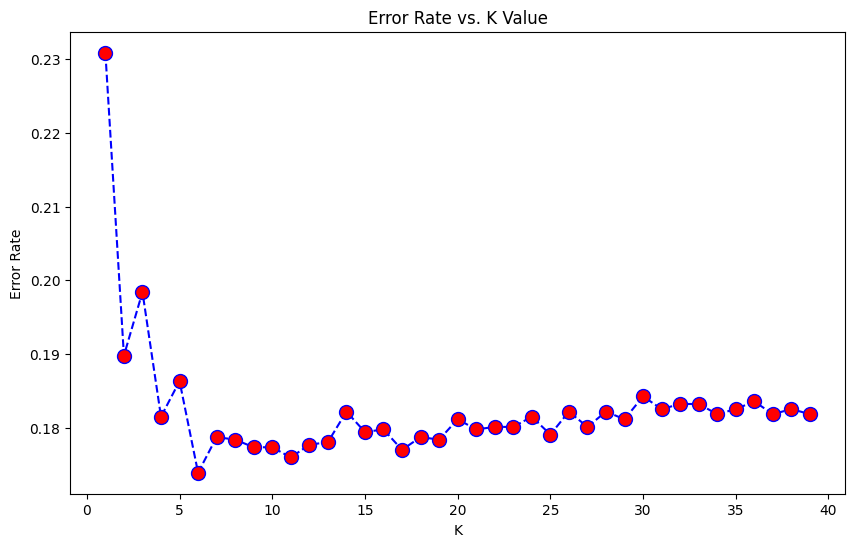

In [ ]:
error_rate = []

# Need plot to find K
for i in range(1,40):

    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(X_train,y_train)
    pred_i = knn_model.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
# NOW WITH K=6
knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

probabilities_knn = knn_model.predict_proba(X_test)  # Predict probabilities for each class
probabilities_positive = probabilities_knn[:, 1]  # Extract probabilities for the positive class

accuracy_knn = knn.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)
print('WITH K=6')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

# Calculate AUC
auc_knn = roc_auc_score(y_test, probabilities_positive)
print("AUC (KNN):", auc_knn)

KNN accuracy: 0.8260869565217391
WITH K=6


[[2218   59]
 [ 445  176]]


              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2277
           1       0.75      0.28      0.41       621

    accuracy                           0.83      2898
   macro avg       0.79      0.63      0.65      2898
weighted avg       0.81      0.83      0.79      2898

AUC (KNN): 0.8054058048807051


In [ ]:
# SVM model
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

#Predictions
predictions_svm = svc_model.predict(X_test)
decision_values_svm = svc_model.decision_function(X_test)  # Use decision function for AUC calculation
print(confusion_matrix(y_test, predictions_svm))
print(classification_report(y_test, predictions_svm))

# Calculate AUC
auc_svm = roc_auc_score(y_test, decision_values_svm)
print("AUC (SVM):", auc_svm)

[[2195   82]
 [ 370  251]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2277
           1       0.75      0.40      0.53       621

    accuracy                           0.84      2898
   macro avg       0.80      0.68      0.72      2898
weighted avg       0.83      0.84      0.83      2898

AUC (SVM): 0.8135319448068872


In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)
print("Random Forest accuracy:", accuracy_rf)
print(confusion_matrix(y_test, predictions_rf))
print(classification_report(y_test, predictions_rf))

# Calculate AUC
probabilities_rf = rf_model.predict_proba(X_test)[:, 1]  # Use probabilities of the positive class
auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Random Forest AUC:", auc_rf)

# Fetch importance
importances = rf_model.feature_importances_
feature_importances = {feature: importance for feature, importance in zip(features, importances)}

# Sorted feature importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

Random Forest accuracy: 0.8429951690821256
[[2173  104]
 [ 351  270]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      2277
           1       0.72      0.43      0.54       621

    accuracy                           0.84      2898
   macro avg       0.79      0.69      0.72      2898
weighted avg       0.83      0.84      0.83      2898

Random Forest AUC: 0.838074082560535
Feature: t2_BMI, Importance: 0.07696170806787522
Feature: t1_BMI, Importance: 0.05878817663758076
Feature: t1_waist_y, Importance: 0.04355176422697386
Feature: t2_waist_y, Importance: 0.03689554103934303
Feature: t1_gamgt, Importance: 0.028902934104297482
Feature: t2_gamgt, Importance: 0.027891836749773052
Feature: t1_Triglyceride_y, Importance: 0.024279980569057034
Feature: t2_HOMA_IR, Importance: 0.021775588290081433
Feature: t2_Triglyceride_y, Importance: 0.021064473181583842
Feature: t2_w, Importance: 0.02058196141985922
Feature: t1_VLDL_C, Importance: 0.0

In [ ]:
# Try df9_b
# features and target variables setup
features = df9_b.columns.drop(['t3_MAFLD'])
target = 't3_MAFLD'
X = df9_b[features]
y = df9_b[target]

#Deal with missing values
# TODO, need discussion
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Resolve the log model cannot converge issue
# Standarize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101)

In [ ]:
# SVM model
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

#Predictions
predictions_svm = svc_model.predict(X_test)
decision_values_svm = svc_model.decision_function(X_test)  # Use decision function for AUC calculation
print(confusion_matrix(y_test, predictions_svm))
print(classification_report(y_test, predictions_svm))

# Calculate AUC
auc_svm = roc_auc_score(y_test, decision_values_svm)
print("AUC (SVM):", auc_svm)

[[2205   72]
 [ 462  159]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2277
           1       0.69      0.26      0.37       621

    accuracy                           0.82      2898
   macro avg       0.76      0.61      0.63      2898
weighted avg       0.80      0.82      0.78      2898

AUC (SVM): 0.7699504319962207


In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test,y_test)
print("Random Forest accuracy:",accuracy_rf)
print(confusion_matrix(y_test,predictions_rf))
print(classification_report(y_test,predictions_rf))

# Fetch importance
importances = rf_model.feature_importances_
feature_importances = {feature: importance for feature, importance in zip(features, importances)}

# Sorted feature importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

Random Forest accuracy: 0.8233264320220842
[[2186   91]
 [ 421  200]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      2277
           1       0.69      0.32      0.44       621

    accuracy                           0.82      2898
   macro avg       0.76      0.64      0.67      2898
weighted avg       0.81      0.82      0.80      2898

Feature: t2_Insulin, Importance: 0.030941334649584783
Feature: t1_VLDL_C, Importance: 0.030735971444925448
Feature: t2_HOMA_IR, Importance: 0.02995584795207322
Feature: t2_w, Importance: 0.029935790482567084
Feature: t2_VLDL_C, Importance: 0.029796077969488168
Feature: t1_HOMA_IR, Importance: 0.02865940276793523
Feature: t1_HS_CRP, Importance: 0.0267690224793931
Feature: t1_Insulin, Importance: 0.026143918304433432
Feature: t1_HDL_C_y, Importance: 0.02549059889129552
Feature: t1_ALT_GPT, Importance: 0.024537994139279977
Feature: t1_Uric_Acid, Importance: 0.02432620926857183
Feature: t1_w, Importa